In [1]:
import pandas as pd
from plantd_modeling import configuration, metrics


In [2]:
exp = configuration.Experiment.load_file("test-pipeline.chris-test-2.json")

In [3]:
exp.metrics

,extract_phase,load_phase,transform_phase
time,,,
2023-10-14 04:43:49,0.000000,0.000000,0.000000
2023-10-14 04:44:04,0.000000,0.000000,0.000000
2023-10-14 04:44:19,5.266667,6.133333,14.733333
2023-10-14 04:44:34,27.000000,26.066667,57.200000
2023-10-14 04:44:49,28.533333,26.066667,54.600000
2023-10-14 04:45:04,27.733333,23.933333,55.400000
2023-10-14 04:45:19,44.466667,23.666667,49.733333
2023-10-14 04:45:34,55.992534,24.463405,52.326356
2023-10-14 04:45:49,57.055256,21.995601,38.059055


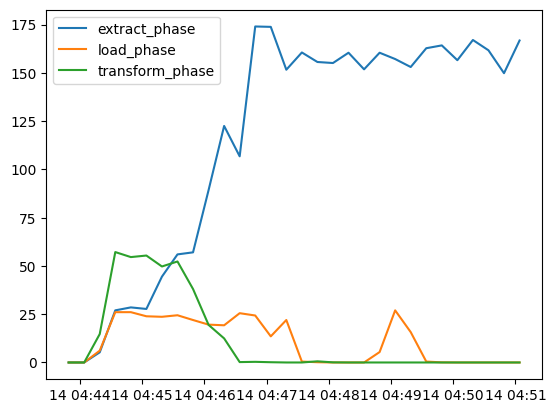

In [4]:
# plot this data
import matplotlib.pyplot as plt

plt.plot(exp.metrics[0:30])
# add legend
plt.legend(exp.metrics.columns)


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from plantd_modeling import metrics
runs = ["low-bad", "low-good", "nom-bad", "nom-good"]

for run in runs:
    # Load the CSV file into a pandas DataFrame
    #df = pd.read_csv(f"fakeredis/simulation_test-{run}-tri.csv")
    df = pd.read_csv(io.StringIO(metrics.redis.load_str("simulation_traffic", "test-{run}-tri")), index_col=0, parse_dates=True)

    print(df.head())
    #pri#nt(df)
    # Convert the "date" column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set the "date" column as the index
    df.set_index("date", inplace=True)

    # Limit to June 30 through July 7
    #df = df.loc["2025-06-23":"2025-07-07"]

    # Plot the columns "cost", "scaleout", "hourly", "queue_len", "latency_fifo", "throughput", "scaleout" by date
    df[["hourly" ]].plot()  #, "throughput""hourly",
    #
    # Add labels and a legend
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Simulation Results: {run}")
    plt.legend()

    # Show the plot
    plt.show()


NameError: name 'metrics' is not defined

In [51]:
import json

print("{:<10} {:<10} {:<10} {:<20} {:<20} {:<20} {:<10}".format("run", "cost", "latency", "avg_throughput_rph", "max_throughput_rph", "pct_latency_met", "sla_met"))
for run in runs:
    inf = json.load(open(f"fakeredis/simulation_test-{run}-tri.json"))
    print("{:<10} {:<10.2f} {:<10.2f} {:<20.2f} {:<20.2f} {:<20.2f} {:<10}".format(run, inf["total_cost"], inf["avg_latency_s"], inf["avg_throughput_rph"], inf["max_throughput_rph"], inf["sla_check"]["pct_latency_met"], inf["sla_check"]["sla_met"]))


run        cost       latency    avg_throughput_rph   max_throughput_rph   pct_latency_met      sla_met   
low-bad    162.43     60.00      3.53                 9.23                 100.00               True      
low-good   434.47     60.00      3.53                 9.23                 100.00               True      
nom-bad    3783.47    60.00      102.88               269.43               100.00               True      
nom-good   7576.17    60.00      102.88               269.43               100.00               True      
